# Test of class Hamiltonian_QED



This notebook uses the class in 'Hamiltonian_QED_oprt.py' and 'Hamiltonian_QED_sym.py' that builds the Hamiltonian in terms of Pauli matrices.


In [1]:
import qiskit

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations

In [4]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
import primme

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_81573/3415147788.py:4: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


##### Class Hamilt

In [5]:
#class input parameters:
n_sites = [2,4]#how many sites for every dimension
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 

#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 3

In [6]:
latt = HCLattice(n_sites,pbc=pbc)


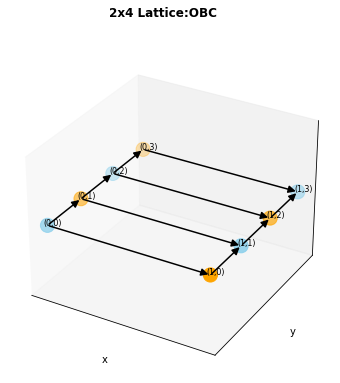

In [7]:
#TODO: in this case no conditions applied
latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)
#only dynamical fields after Gauss law applied
#latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H.e_op_free)#,savefig_dir='.')

In [8]:
#latt.func_qstatic_dist()#ch_val=1)
#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st ) for st in latt.distances_coord]#,savefig_dir='.')

In [9]:
hamilt_sym = HamiltonianQED_sym(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian)

class_H_oprt = HamiltonianQED_oprt(
                        latt,
                        hamilt_sym,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.023750782012939453 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 0.7107751369476318 seconds
>> Suppression term built.  Execution time: 0.004626750946044922 seconds


In [10]:
def sparse_mem2(sparsem):
    """Return the memory in GiB of a sparse matrix"""
    return (sparsem.data.nbytes + sparsem.indptr.nbytes + sparsem.indices.nbytes)/1024**3

##### ED spectrum

In [11]:
import scipy.sparse as sp

In [12]:
Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot#.to_matrix(sparse=True)
    h_b_sparse = class_H_oprt.hamiltonian_mag_pauli#.to_matrix(sparse=True) #plaquette
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
#spectrum, eigenvectors_matrix = eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA",ncv = 30)#
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
print(f'Spectrum of {latt.dims}D_'+'x'.join([str(i) for i in n_sites])+f'H with mbasis{magnetic_basis}puregauge{puregauge} pbc{pbc}_g{g}_l{l}_L{L}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}, encoding:'+encoding)
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
                print(f'E_{kk}=',round(evalu,8))

if class_H_oprt.len_e_op != 0:
    eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()#.conj().T
    eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
    plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real
    #plaq = (eig0cj.dot((h_b_sparse).dot(eig0)).real)/len(latt.plaq_list) 
    print(f'plaq={plaq}')
                
                         

5.36e-06 Gb
Spectrum of 2D_2x4H with mbasisFalsepuregaugeTrue pbcFalse_g0.5_l1_L8_factE1_factB1_m3_Omega1, encoding:gray
E_0= -7.77257715
E_1= -4.84638535
E_2= -4.68164043
plaq=0.7041063744786762


5.36e-06 Gb
Spectrum of 2D_2x4H with mbasisFalsepuregaugeTrue pbcFalse_g0.5_l1_L8_factE1_factB1_m3_Omega1, encoding:gray
E_0= -7.77257715
E_1= -4.84638535
E_2= -4.68164043
plaq=0.7041063744787524

Spectrum of 2D_2x3H with mbasisTruepuregaugeTrue pbcFalse_g0.1_l1_L8_factE1_factB1_m3_Omega1, encoding:ed
E_0= -199.09117537
E_1= -192.51972172
E_2= -192.24965882
plaq=0.999748619699202

Spectrum of H with mbasisFalsepuregaugeTrue pbcTrue_g1_l1_factE1_factB1_m3_Omega1_TNFalse, encoding:ed
E_0= -1.0066823
E_1= -0.26964819
plaq=0.4623451128853849


Spectrum of H with mbasisFalsepuregaugeFalse pbcTrue_g1_l1_factE1_factB1_m3_Omega1_TNFalse, encoding:ed
E_0= -7.30371524
E_1= -6.55004296
E_2= -6.53959578
plaq= 0.45649020277218433